
<a href="https://colab.research.google.com/github/SMTorg/smt/blob/master/tutorial/Kernels/SMT_Kernel_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<div class="jumbotron text-left"><b>

This tutorial describes how to use Kernels, a module of the SMT toolbox. It implements kernel engineering within the SMT 2.0 Toolbox.
</div>

Nicolas GONEL, Paul SAVES ONERA/DTIS/M2CI
Joseph MORLIER ISAE-SUPAERO,ICA

October 2024 - `SMT version 2.7.0`
</b>

<p class="alert alert-success" style="padding:1em">
To use SMT, please follow this link : https://github.com/SMTorg/SMT/blob/master/README.md. The documentation is available here: http://smt.readthedocs.io/en/latest/
</p>

The reference paper for Kernels is available
here hhttps://www.sciencedirect.com/journal/advances-in-engineering-software/vol/188/suppl/C

In [1]:
# %pip install smt

In [2]:
from sklearn.datasets import fetch_openml
from smt.kernels import SquarSinExp
from smt.kernels import Kernel
from smt.kernels import Matern32

from smt.kernels import PowExp
import numpy as np
from smt.surrogate_models import KRG

import matplotlib.pyplot as plt
import polars as pl

import datetime

# Forecasting of CO2 level on Mona Loa dataset using Gaussian process regression (GPR)
This example is based on Section 5.4.3 of “Gaussian Processes for Machine Learning”. It illustrates an example of complex kernel engineering and hyperparameter optimization using gradient ascent on the log-marginal-likelihood. The data consists of the monthly average atmospheric CO2 concentrations (in parts per million by volume (ppm)) collected at the Mauna Loa Observatory in Hawaii, between 1958 and 2001. The objective is to model the CO2 concentration as a function of the time and extrapolate for years after 2001. (see scikit-learn https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html)

In [3]:
co2 = fetch_openml(data_id=41187, as_frame=True)

In [4]:
co2_data = pl.DataFrame(co2.frame[["year", "month", "day", "co2"]]).select(
    pl.date("year", "month", "day"), "co2"
)

co2_data = (
    co2_data.sort(by="date")
    .group_by_dynamic("date", every="1mo")
    .agg(pl.col("co2").mean())
    .drop_nulls()
)


Xcomp = np.copy(
    co2_data.select(
        pl.col("date").dt.year() + pl.col("date").dt.month() / 12
    ).to_numpy()
)
ycomp = np.copy(co2_data["co2"].to_numpy())


X = co2_data.select(
    pl.col("date").dt.year() + pl.col("date").dt.month() / 12
).to_numpy()[:100]
y = co2_data["co2"].to_numpy()[:100]
X_smt = X.reshape(-1)[:100]

# Defining a new kernel

Here, we define the rational quadratic kernel that inherit from the class ```Kernel```

In [5]:
class Rat_quad(Kernel):
    def __call__(self, d, grad_ind=None, hess_ind=None, derivative_params=None):
        n = self.theta.shape[0]
        theta4 = self.theta[: n // 2]
        theta5 = self.theta[n // 2 :]
        r3 = (1 + d**2 / (2 * theta4 * theta5)) ** (-theta4)
        return r3

# Combine several kernels

Here, we define the kernel ```k``` as a sum and product between different kernels.


In [6]:
k = (
    Matern32([0.01])
    + SquarSinExp([0.01, 0.01]) * PowExp([0.01])
    + Rat_quad([0.01, 0.01])
)

# Using the user-defined kernel to forecast the future

In [7]:
sm = KRG(pow_exp_power=2.0, corr=k, hyper_opt="Cobyla", poly="linear", n_start=50)
sm.set_training_values(X, y)
sm.train()

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 100
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  5.0453067


In [8]:
today = datetime.datetime.now()
current_month = 2001 + today.month / 12
X_test = np.linspace(start=1958, stop=current_month, num=1_000).reshape(-1, 1)
mean_y_pred = sm.predict_values(X_test)
s2 = sm.predict_variances(X_test)

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1000
   
   Predicting ...
   Predicting - done. Time (sec):  0.0198989
   
   Prediction time/pt. (sec) :  0.0000199
   


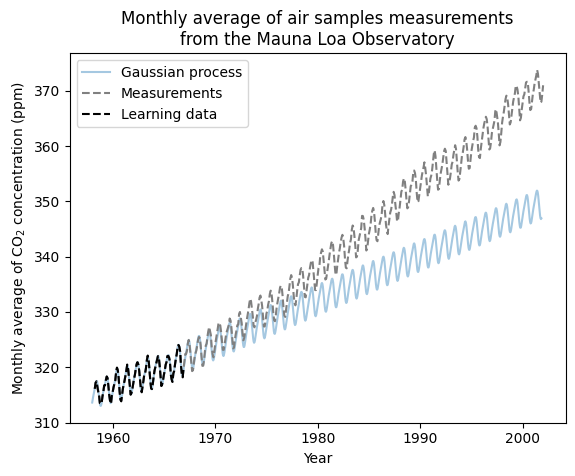

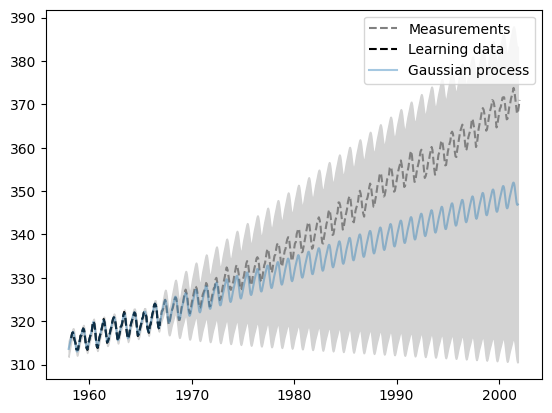

In [9]:
plt.plot(X_test, mean_y_pred, color="tab:blue", alpha=0.4, label="Gaussian process")
plt.plot(Xcomp, ycomp, color="grey", linestyle="dashed", label="Measurements")
plt.plot(X, y, color="black", linestyle="dashed", label="Learning data")

plt.legend()
plt.xlabel("Year")
plt.ylabel("Monthly average of CO$_2$ concentration (ppm)")
_ = plt.title(
    "Monthly average of air samples measurements\nfrom the Mauna Loa Observatory"
)
_, axs = plt.subplots(1)

# add a plot with variance

plt.plot(Xcomp, ycomp, color="grey", linestyle="dashed", label="Measurements")
plt.plot(X, y, color="black", linestyle="dashed", label="Learning data")
axs.plot(X_test, mean_y_pred, color="tab:blue", alpha=0.4, label="Gaussian process")
axs.fill_between(
    np.ravel(X_test),
    np.ravel(mean_y_pred - 3 * np.sqrt(s2)),
    np.ravel(mean_y_pred + 3 * np.sqrt(s2)),
    color="lightgrey",
)


axs.legend()
plt.show()

# Predicting future CO2 levels

### The data indicated an unexpected increase in CO2 level of around +1.8 std

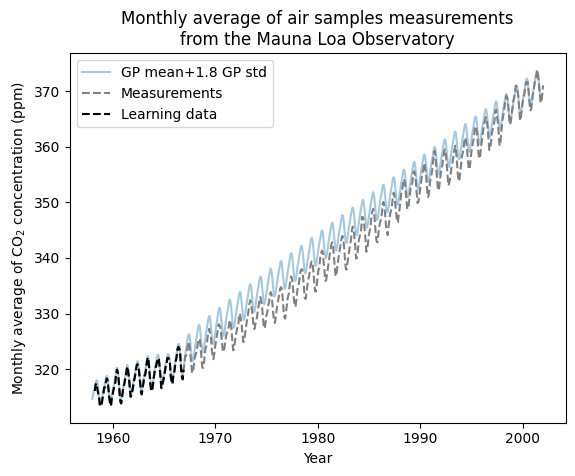

In [10]:
plt.plot(
    X_test,
    mean_y_pred + 1.8 * np.sqrt(s2),
    color="tab:blue",
    alpha=0.4,
    label="GP mean+1.8 GP std",
)
plt.plot(Xcomp, ycomp, color="grey", linestyle="dashed", label="Measurements")
plt.plot(X, y, color="black", linestyle="dashed", label="Learning data")

plt.legend()
plt.xlabel("Year")
plt.ylabel("Monthly average of CO$_2$ concentration (ppm)")
_ = plt.title(
    "Monthly average of air samples measurements\nfrom the Mauna Loa Observatory"
)


axs.legend()
plt.show()

### The interpretation of such issue is that the increase in CO2 is not linear but exponential, the climate change is faster every day.

## Future forecasting
### Based on the previous data, here is the future predicted CO2 emissions

In [17]:
sm.set_training_values(Xcomp[300:], ycomp[300:])
sm.train()

___________________________________________________________________________
      
                                  Kriging
___________________________________________________________________________
      
 Problem size
      
         # training points.        : 221
      
___________________________________________________________________________
      
 Training
      
      Training ...
      Training - done. Time (sec): 16.7609460


In [26]:
today = datetime.datetime.now()
current_month = today.year + today.month / 12
X_test = np.linspace(start=1984, stop=current_month, num=1_000).reshape(-1, 1)
mean_y_pred = sm.predict_values(X_test)
s2 = sm.predict_variances(X_test)

___________________________________________________________________________
      
 Evaluation
      
         # eval points. : 1000
      
      Predicting ...
      Predicting - done. Time (sec):  0.0448437
      
      Prediction time/pt. (sec) :  0.0000448
      


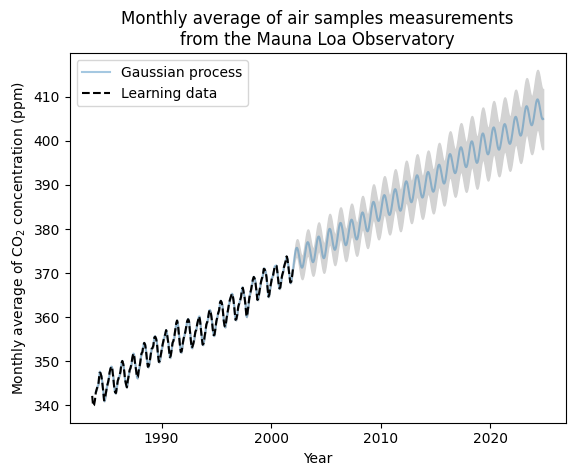

In [39]:
plt.plot(X_test, mean_y_pred, color="tab:blue", alpha=0.4, label="Gaussian process")
plt.plot(
    Xcomp[300:], ycomp[300:], color="black", linestyle="dashed", label="Learning data"
)

plt.legend()
plt.xlabel("Year")
plt.ylabel("Monthly average of CO$_2$ concentration (ppm)")
_ = plt.title(
    "Monthly average of air samples measurements\nfrom the Mauna Loa Observatory"
)


plt.fill_between(
    np.ravel(X_test),
    np.ravel(mean_y_pred - 1 * np.sqrt(s2)),
    np.ravel(mean_y_pred + 1 * np.sqrt(s2)),
    color="lightgrey",
)

plt.legend()
plt.show()